In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval maite-datasets
except Exception:
    pass

In [2]:
import numpy as np
import polars as pl
from maite_datasets.object_detection import VOCDetection

# Load the classes from DataEval that are helpful for EDA
from dataeval.config import set_max_processes
from dataeval.core import calculate, label_stats
from dataeval.core.flags import ImageStats
from dataeval.data import Metadata
from dataeval.evaluators.linters import Duplicates, Outliers

# Print all rows of dataframes
_ = pl.Config.set_tbl_rows(-1)

# Set the random value
rng = np.random.default_rng(213)

# Set multiprocessing for DataEval stats
set_max_processes(4)

In [3]:
# Helper method to plot sample images by class
def plot_sample_images_by_class(dataset, image_indices_per_class) -> None:
    import matplotlib.pyplot as plt

    # Plot random images from each category
    _, axs = plt.subplots(5, 4, figsize=(8, 10))

    for ax, (category, indices) in zip(axs.flat, image_indices_per_class.items()):
        # Randomly select an index from the list of indices
        ax.imshow(dataset[rng.choice(indices)][0].transpose(1, 2, 0))
        ax.set_title(dataset.metadata["index2label"][category])
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Helper method to plot images of interest
def plot_sample_outlier_images_by_metric(dataset, outlier_class, outlier_result, metric, layout) -> None:
    import matplotlib.pyplot as plt
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize

    # Filter issues DataFrame for the specific metric
    metric_issues = outlier_result.issues.filter(pl.col("metric_name") == metric)
    image_ids = metric_issues["image_id"].unique().to_list()

    if not image_ids:
        print(f"No images flagged for metric: {metric}")
        return

    # Get all metric values for the entire dataset to understand the distribution
    all_metric_values = outlier_class.stats["stats"][metric]
    quantiles = np.quantile(all_metric_values, [0, 0.25, 0.5, 0.75, 1])
    median = quantiles[2]

    # Calculate distance from median for each flagged image and sort by distance (descending)
    metric_values_with_ids = []
    for img_id in image_ids:
        metric_value = metric_issues.filter(pl.col("image_id") == img_id)["metric_value"][0]
        distance_from_median = abs(metric_value - median)
        metric_values_with_ids.append((img_id, metric_value, distance_from_median))

    # Sort by distance from median (most outlier first)
    metric_values_with_ids.sort(key=lambda x: x[2], reverse=True)

    # Create figure with space for colorbar
    fig = plt.figure(figsize=(12, layout[0] * 4))

    # Create grid spec with extra space for colorbar
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(
        layout[0],
        layout[1] + 1,
        width_ratios=[1] * layout[1] + [0.05],
        hspace=0.4,
        wspace=0.1,
        left=0.05,
        right=0.92,
        top=0.96,
        bottom=0.02,
    )

    # Determine number of samples to plot
    n_samples = min(int(np.prod(layout)), len(image_ids))

    # Create colormap normalization based on full metric distribution
    vmin, vmax = quantiles[0], quantiles[4]
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("viridis")

    # Plot images
    for i in range(n_samples):
        row = i // layout[1]
        col = i % layout[1]
        ax = fig.add_subplot(gs[row, col])

        img_id, metric_value, _ = metric_values_with_ids[i]

        # Get color for this metric value
        color = cmap(norm(metric_value))

        # Plot image
        ax.imshow(dataset[img_id][0].transpose(1, 2, 0))

        # Place metric details as footer below the image using xlabel (black text for legibility)
        ax.set_xlabel(f"index: {img_id}\n{metric}: {np.round(metric_value, 3)}", fontsize=9, color="black")

        # Turn off ticks but keep spines for colored border
        ax.set_xticks([])
        ax.set_yticks([])

        # Add 5-pixel colored border to indicate extremeness
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(5)
            spine.set_visible(True)

    # Add colorbar with quantile markers
    cbar_ax = fig.add_subplot(gs[:, -1])
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_ticks([])

    # Add quantile markers on colorbar
    quantile_labels = ["Min (Q0)", "Q1 (25%)", "Median (Q2)", "Q3 (75%)", "Max (Q4)"]
    for q_val, q_label in zip(quantiles, quantile_labels):
        cbar.ax.axhline(q_val, color="black", linestyle="--", linewidth=0.8, alpha=0.7)
        cbar.ax.text(
            1.5,
            q_val,
            f"{q_label}\n{np.round(q_val, 2)}",
            va="center",
            fontsize=8,
            transform=cbar.ax.get_yaxis_transform(),
        )

    # Add overall title with more top space
    fig.suptitle(f'Outlier Images for "{metric}" (sorted by distance from median)', fontsize=12, y=0.99)

    plt.show()

In [4]:
# Download the data and then load it as a torch Tensor
ds = VOCDetection("./data", image_set="train", year="2012", download=True)
print(ds)

VOCDetection Dataset
--------------------
    Year: 2012
    Transforms: []
    Image Set: train
    Metadata: {'id': 'VOCDetection_train', 'index2label': {0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}, 'split': 'train'}
    Path: /builds/jatic/aria/dataeval/docs/source/notebooks/data/vocdataset/VOCdevkit/VOC2012
    Size: 5717


In [5]:
# Calculate basic label statistics from the dataset
lstats = label_stats(((lbl for lbl in d[1].labels) for d in ds), ds.index2label)

# View per_class data as a DataFrame
pl.DataFrame(
    {
        "class_name": list(ds.index2label.values()),
        "label_count": [lstats["label_counts_per_class"][k] for k in ds.index2label],
        "image_count": [lstats["image_counts_per_class"][k] for k in ds.index2label],
    }
)

shape: (20, 3)
┌─────────────┬─────────────┬─────────────┐
│ class_name  ┆ label_count ┆ image_count │
│ ---         ┆ ---         ┆ ---         │
│ str         ┆ i64         ┆ i64         │
╞═════════════╪═════════════╪═════════════╡
│ aeroplane   ┆ 470         ┆ 328         │
│ bicycle     ┆ 410         ┆ 281         │
│ bird        ┆ 592         ┆ 399         │
│ boat        ┆ 508         ┆ 264         │
│ bottle      ┆ 749         ┆ 399         │
│ bus         ┆ 317         ┆ 219         │
│ car         ┆ 1191        ┆ 621         │
│ cat         ┆ 609         ┆ 540         │
│ chair       ┆ 1457        ┆ 656         │
│ cow         ┆ 355         ┆ 155         │
│ diningtable ┆ 373         ┆ 318         │
│ dog         ┆ 768         ┆ 636         │
│ horse       ┆ 377         ┆ 238         │
│ motorbike   ┆ 375         ┆ 274         │
│ person      ┆ 5019        ┆ 2142        │
│ pottedplant ┆ 557         ┆ 289         │
│ sheep       ┆ 509         ┆ 171         │
│ sofa        ┆ 399         ┆ 359         │
│ train       ┆ 327         ┆ 275         │
│ tvmonitor   ┆ 412         ┆ 299         │
└─────────────┴─────────────┴─────────────┘

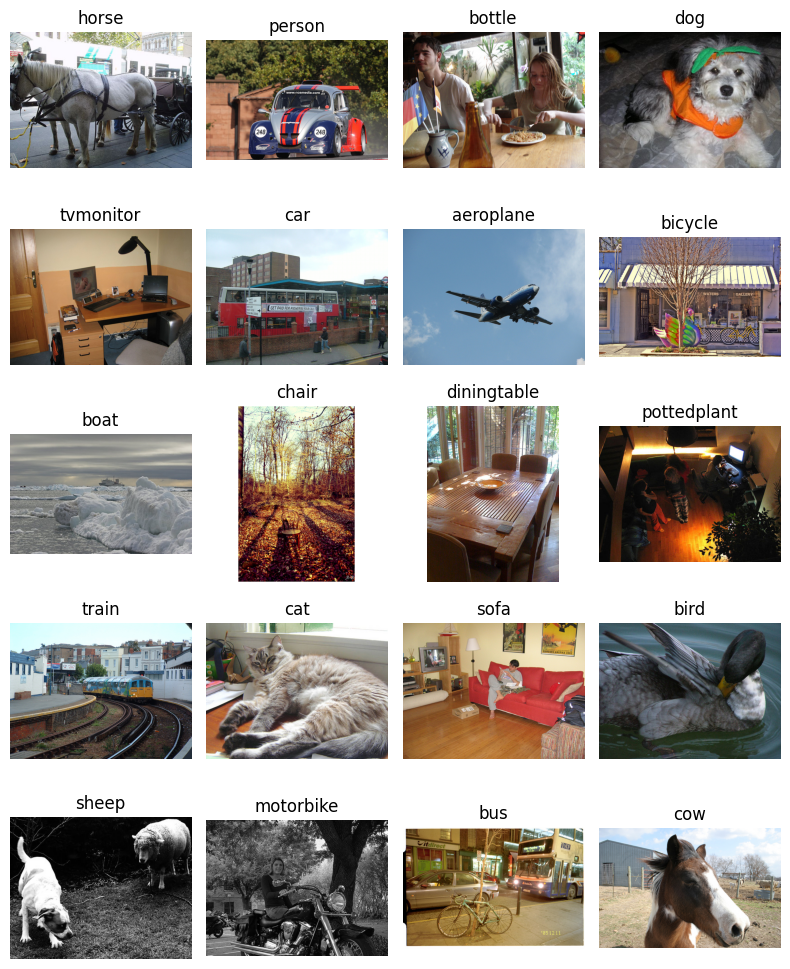

In [6]:
plot_sample_images_by_class(ds, lstats["image_indices_per_class"])

In [7]:
# This cell takes about 1-5 minutes to run depending on your hardware

# Initialize the Outliers class
outliers = Outliers(outlier_method="zscore")

# Find the extreme images
outlier_imgs = outliers.evaluate(ds)

# View the number of extreme images
print(f"Number of images with extreme values: {len(outlier_imgs)}")

Processing images for DimensionStat, PixelStat, VisualStat:   0%|          | 0/5717 [00:00<?, ?it/s]

Number of images with extreme values: 480


In [8]:
# List the metrics with an extreme value
outlier_imgs.aggregate_by_metric()

shape: (15, 2)
┌──────────────┬───────┐
│ metric_name  ┆ count │
│ ---          ┆ ---   │
│ cat          ┆ u32   │
╞══════════════╪═══════╡
│ size         ┆ 173   │
│ entropy      ┆ 123   │
│ contrast     ┆ 92    │
│ skew         ┆ 89    │
│ zeros        ┆ 77    │
│ kurtosis     ┆ 73    │
│ brightness   ┆ 52    │
│ width        ┆ 43    │
│ var          ┆ 35    │
│ mean         ┆ 29    │
│ height       ┆ 22    │
│ std          ┆ 22    │
│ darkness     ┆ 20    │
│ aspect_ratio ┆ 5     │
│ sharpness    ┆ 2     │
└──────────────┴───────┘

In [9]:
# Create the Metadata object
md = Metadata(ds)

# List the outliers by class label
outlier_imgs.aggregate_by_class(md)

Processing datum metadata:   0%|          | 0/5717 [00:00<?, ?it/s]

shape: (21, 17)
┌─────────────┬──────────────┬────────────┬──────────┬───┬─────┬───────┬───────┬───────┐
│ class_name  ┆ aspect_ratio ┆ brightness ┆ contrast ┆ … ┆ var ┆ width ┆ zeros ┆ Total │
│ ---         ┆ ---          ┆ ---        ┆ ---      ┆   ┆ --- ┆ ---   ┆ ---   ┆ ---   │
│ cat         ┆ u32          ┆ u32        ┆ u32      ┆   ┆ u32 ┆ u32   ┆ u32   ┆ u32   │
╞═════════════╪══════════════╪════════════╪══════════╪═══╪═════╪═══════╪═══════╪═══════╡
│ person      ┆ 2            ┆ 18         ┆ 86       ┆ … ┆ 9   ┆ 31    ┆ 52    ┆ 518   │
│ aeroplane   ┆ 0            ┆ 25         ┆ 6        ┆ … ┆ 1   ┆ 1     ┆ 1     ┆ 197   │
│ bird        ┆ 0            ┆ 17         ┆ 6        ┆ … ┆ 0   ┆ 1     ┆ 7     ┆ 165   │
│ chair       ┆ 0            ┆ 6          ┆ 21       ┆ … ┆ 2   ┆ 5     ┆ 24    ┆ 123   │
│ bottle      ┆ 3            ┆ 2          ┆ 20       ┆ … ┆ 4   ┆ 6     ┆ 10    ┆ 104   │
│ cat         ┆ 0            ┆ 2          ┆ 10       ┆ … ┆ 9   ┆ 4     ┆ 11    ┆ 87    │
│ car         ┆ 0            ┆ 0          ┆ 9        ┆ … ┆ 4   ┆ 5     ┆ 11    ┆ 75    │
│ dog         ┆ 0            ┆ 3          ┆ 4        ┆ … ┆ 2   ┆ 7     ┆ 5     ┆ 72    │
│ boat        ┆ 0            ┆ 2          ┆ 2        ┆ … ┆ 0   ┆ 0     ┆ 1     ┆ 55    │
│ tvmonitor   ┆ 0            ┆ 0          ┆ 5        ┆ … ┆ 0   ┆ 2     ┆ 23    ┆ 49    │
│ motorbike   ┆ 0            ┆ 1          ┆ 7        ┆ … ┆ 2   ┆ 2     ┆ 4     ┆ 42    │
│ bicycle     ┆ 0            ┆ 1          ┆ 3        ┆ … ┆ 0   ┆ 8     ┆ 2     ┆ 37    │
│ sofa        ┆ 0            ┆ 0          ┆ 4        ┆ … ┆ 5   ┆ 3     ┆ 3     ┆ 33    │
│ train       ┆ 0            ┆ 3          ┆ 0        ┆ … ┆ 5   ┆ 2     ┆ 2     ┆ 33    │
│ pottedplant ┆ 0            ┆ 1          ┆ 5        ┆ … ┆ 12  ┆ 0     ┆ 5     ┆ 31    │
│ cow         ┆ 0            ┆ 0          ┆ 1        ┆ … ┆ 3   ┆ 7     ┆ 1     ┆ 30    │
│ bus         ┆ 0            ┆ 0          ┆ 1        ┆ … ┆ 1   ┆ 2     ┆ 0     ┆ 23    │
│ diningtable ┆ 0            ┆ 1          ┆ 3        ┆ … ┆ 2   ┆ 0     ┆ 2     ┆ 19    │
│ horse       ┆ 0            ┆ 0          ┆ 2        ┆ … ┆ 0   ┆ 0     ┆ 0     ┆ 10    │
│ sheep       ┆ 0            ┆ 0          ┆ 1        ┆ … ┆ 2   ┆ 0     ┆ 1     ┆ 10    │
│ Total       ┆ 5            ┆ 82         ┆ 196      ┆ … ┆ 63  ┆ 86    ┆ 165   ┆ 1713  │
└─────────────┴──────────────┴────────────┴──────────┴───┴─────┴───────┴───────┴───────┘

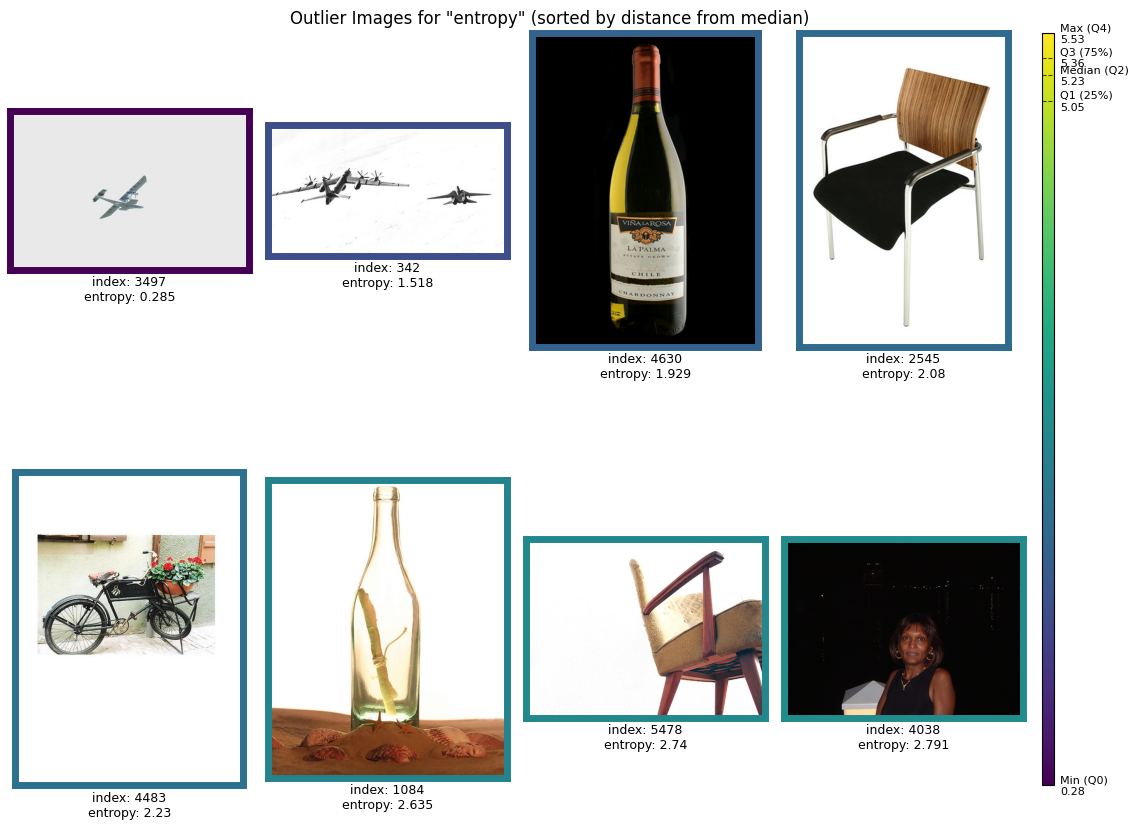

In [10]:
# Plot images flagged for "entropy"
plot_sample_outlier_images_by_metric(ds, outliers, outlier_imgs, "entropy", (2, 4))

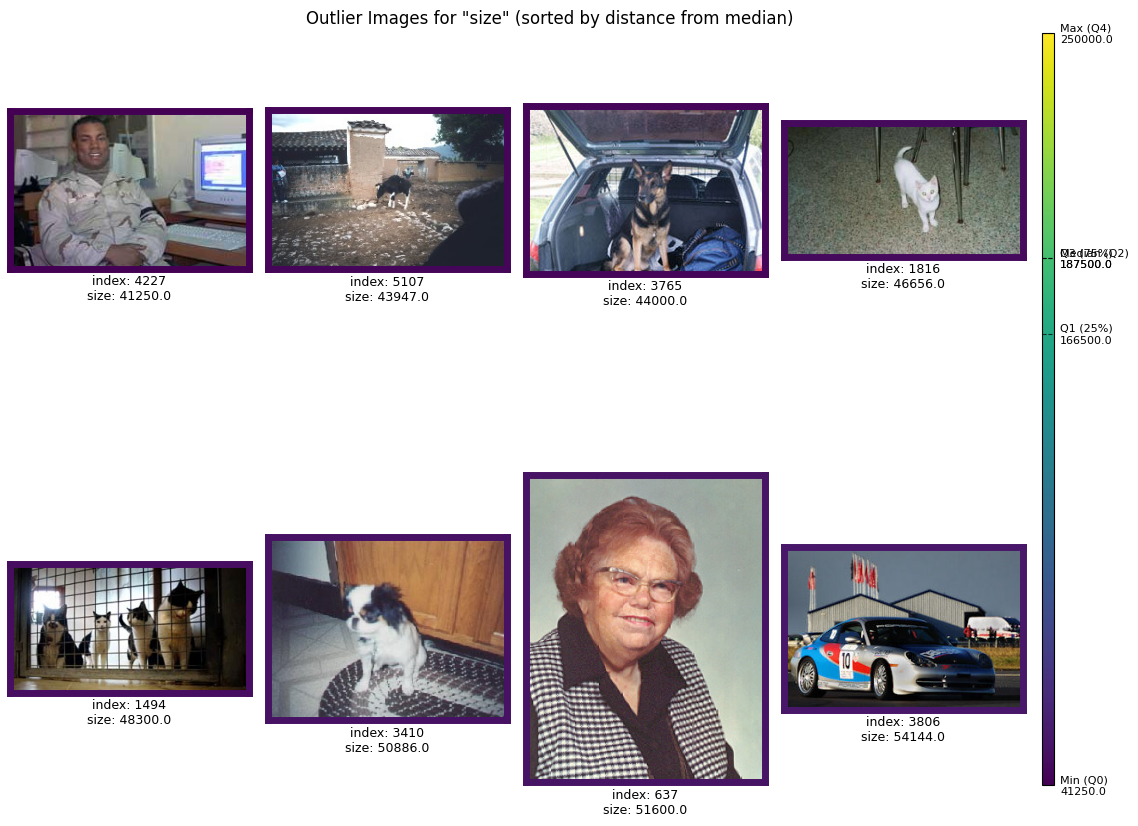

In [11]:
# Plot images flagged for "size"
plot_sample_outlier_images_by_metric(ds, outliers, outlier_imgs, "size", (2, 4))

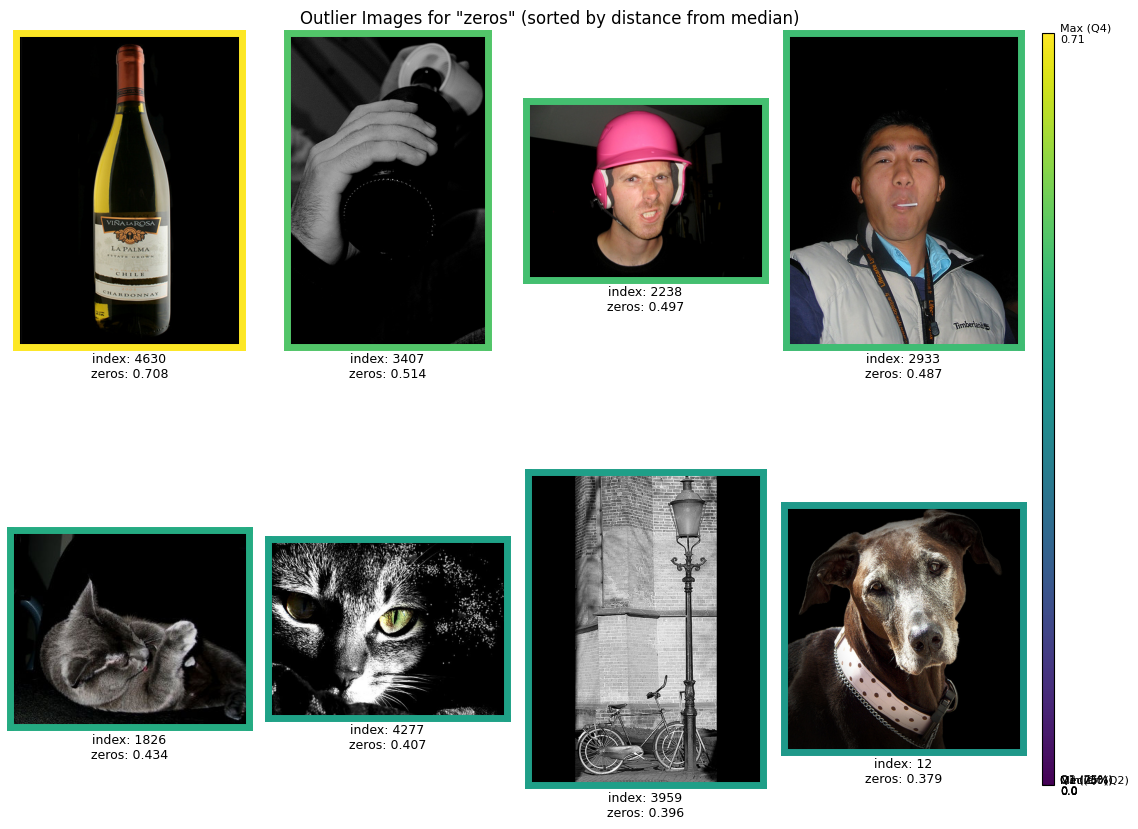

In [12]:
# Plot images flagged for "zeros"
plot_sample_outlier_images_by_metric(ds, outliers, outlier_imgs, "zeros", (2, 4))

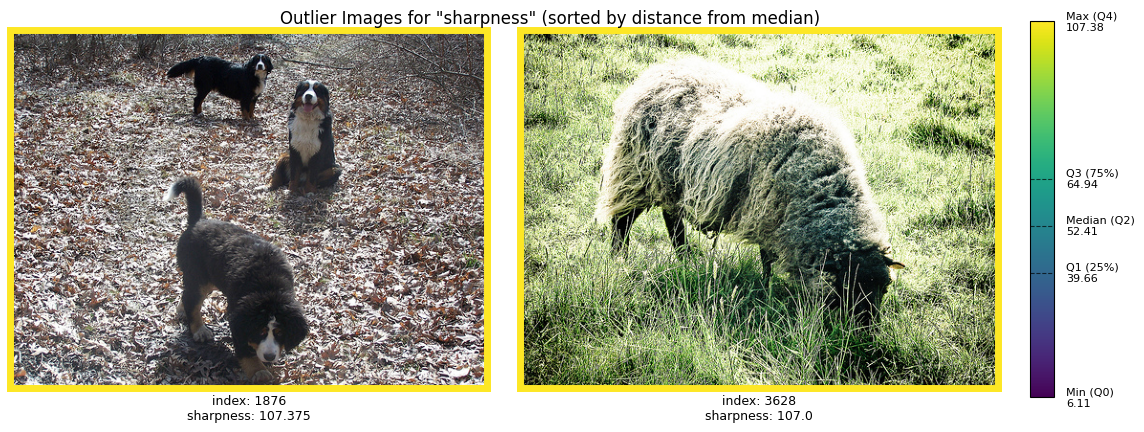

In [13]:
# Plot images flagged for "sharpness"
plot_sample_outlier_images_by_metric(ds, outliers, outlier_imgs, "sharpness", (1, 2))

In [14]:
# Initialize the Duplicates class
dups = Duplicates()

# Find the duplicates
dups.evaluate(ds)

Processing images for HashStat:   0%|          | 0/5717 [00:00<?, ?it/s]

DuplicatesOutput(exact=[], near=[])

In [15]:
# Create exact and duplicate images

# Copy images 23 and 46 to create exact duplicates
# Copy and crop images 5 and 4376 to create near duplicates
dupes = [
    ds[23][0],
    ds[46][0],
    ds[5][0][:, 5:-5, 5:-5],
    ds[4376][0][:, :-5, 5:],
]

dupes_stats = calculate(dupes, None, ImageStats.HASH)

Processing images for HashStat:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# Find the duplicates appended to the dataset
duplicates = dups.from_stats([dups.stats, dupes_stats])
print(f"exact: {duplicates.exact}")
print(f"near: {duplicates.near}")

exact: [{0: [23], 1: [0]}, {0: [46], 1: [1]}]
near: [{0: [5], 1: [2]}, {0: [4376], 1: [3]}]
